In [1]:
using Pkg; 
packages = ["Knet", "AutoGrad", "Random", "Test", "MLDatasets", "CUDA", "Plots", "GR","Statistics",
            "IterTools", "StatsBase", "DSP", "Images", "DelimitedFiles", "MultivariateStats", "PyPlot", "PyCall"];
Pkg.add(packages);

   Updating registry at `C:\Users\volkan\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\volkan\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\volkan\.julia\environments\v1.5\Manifest.toml`


In [1]:
include("../src/modules/TUM69.jl")
include("../src/modules/Preprocess.jl")
include("../src/modules/Network.jl")
include("../src/modules/Utils.jl")

## Third party packages
using Knet: KnetArray, adam, relu, minibatch
using AutoGrad, Knet, CUDA


## Handwritten modules
using .TUM69: load_accel_data   # Data reading
using .Preprocess: process_accel_signal # Preprocessing on the data
using .Network: GCN, train_summarize!, accuracy4, nll4, GenericMLP # Construction of custom network
using .Utils: notify

In [2]:
AutoGrad.set_gc_function(AutoGrad.default_gc)

default_gc (generic function with 1 method)

In [3]:
# Trick from Deniz Hoca to deal with this issue: https://github.com/denizyuret/Knet.jl/issues/524
#=
using Knet
function Knet.KnetArray(x::CuArray{T,N}) where {T,N}
    p = Base.bitcast(Knet.Cptr, pointer(x))
    k = Knet.KnetPtr(p, sizeof(x), Int(CUDA.device().handle), x)
    KnetArray{T,N}(k, size(x))
end
=#

In [4]:
# Array type setting for GPU usage
a_type() = (CUDA.functional() ? KnetArray{Float32} : Array{Float32})

a_type (generic function with 1 method)

In [5]:
# CUDA information
GC.gc(true)
CUDA.device()

LoadError: CUDA.jl did not successfully initialize, and is not usable.
If you did not see any other error message, try again in a new session
with the JULIA_DEBUG environment variable set to 'CUDA'.

In [6]:
path = CUDA.functional() ? "/userfiles/vaydingul20/data/new" : "./../data/trial" # path of the main data
DATA_PATH = isdir(path) && path

"./../data/trial"

In [7]:
X_train, y_train,
X_test, y_test, 
material_dict = @time load_accel_data(DATA_PATH; mode = "baseline");  # Data loading routine

Train accel data is being loaded!
Test accel data is being loaded!
  2.549316 seconds (4.89 M allocations: 166.858 MiB, 1.70% gc time)


In [8]:
println("X_train = ", summary(X_train))
println("y_train = ", summary(y_train))
println("X_test  = ", summary(X_test))
println("y_test  = ", summary(y_test))
println("material_dict = ", summary(material_dict))

X_train = 3-element Array{Array{Float32,1},1}
y_train = 3-element Array{Int8,1}
X_test  = 3-element Array{Array{Float32,1},1}
y_test  = 3-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [9]:
#Preprocessing on the acceleration data
@time X_train_modified, y_train_modified = process_accel_signal(X_train, y_train);
@time X_test_modified, y_test_modified = process_accel_signal(X_test, y_test);

  4.865731 seconds (6.87 M allocations: 364.132 MiB, 3.01% gc time)
  0.117793 seconds (388 allocations: 30.432 MiB)


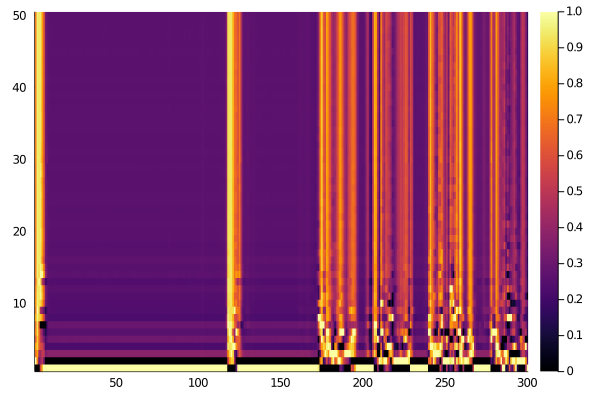

In [21]:
using Plots
heatmap(X_test_modified[:,:,1,1])

In [20]:
println("X_train = ", summary(X_train_modified))
println("y_train = ", summary(y_train_modified))
println("X_test  = ", summary(X_test_modified))
println("y_test  = ", summary(y_test_modified))
println("material_dict = ", summary(material_dict))

X_train = 50×300×1×24 Array{Float32,4}
y_train = 24-element Array{Int8,1}
X_test  = 50×300×1×24 Array{Float32,4}
y_test  = 24-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [42]:
# Some constants that will be used in the network model
MINIBATCH_SIZE = 10
INPUT_SIZE = size(X_test_modified)[1:3]
OUTPUT_SIZE = size(collect(keys(material_dict)))[1];

In [43]:
# Minibatching
dtrn = minibatch(X_train_modified, y_train_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true)
dtst = minibatch(X_test_modified, y_test_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true);

In [44]:
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(25, 150, 1 , relu, 0.0, (1, 1), (1, 1), (2, 2), false)]; 
    hidden=[10], optimizer_type = sgd, lr = 0.15, loss_fnc=nll, accuracy_fnc = accuracy, atype=a_type())

GCN((Main.Network.Conv(P(Array{Float32,4}(25,150,1,1)), P(Array{Float32,4}(1,1,1,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, Array{Float32,N} where N), Main.Network.Dense(P(Array{Float32,2}(10,1064)), P(Array{Float32,1}(10)), Knet.Ops20.relu, 0.0), Main.Network.Dense(P(Array{Float32,2}(69,10)), P(Array{Float32,1}(69)), Knet.Ops20.relu, 0.0)), Knet.Train20.sgd, 0.15, Knet.Ops20.nll, Knet.Ops20.accuracy)

In [45]:
#=
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(3, 3, 50 , relu, 0.0, (1, 1), (1, 1), (2, 2), true),
        (3, 3, 100, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 150, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 200, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (4, 12,400, relu, 0.5, (1, 0), (1, 1), (1, 1), false),
        (1, 1, 250, relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        (1, 1, OUTPUT_SIZE , relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        ]; 
    hidden=[10], optimizer_type = adam, lr = 1e-4, loss_fnc=nll, accuracy_fnc = accuracy, atype=a_type())
=#

In [46]:
model(dtst)

4.233735f0

In [47]:
# Training routine
# Currently, the model is not working due to the issue mentioned in: https://github.com/denizyuret/Knet.jl/issues/624#
# As soon as it is solved, I hope the model will be accurately working.
res = train_summarize!(model, dtrn, dtst; 
                       train_type = "epoch", progress_bar = true ,fig = true, info = true, 
                       epoch = 100, conv_epoch = 50, max_conv_cycle = 20)

┣█▏                  ┫ [5.84%, 263/4500, 11:16/03:12:48, 1.31s/i]  

LoadError: InterruptException: